In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import os
import sys
import plotly.graph_objects as go 
dir_path = os.path.abspath('')
sys.path.append(dir_path + '/../')
from labbiofisica import Interpolazione, final_val

from scipy.optimize import curve_fit
from scipy.stats import norm
import scipy.stats as stats


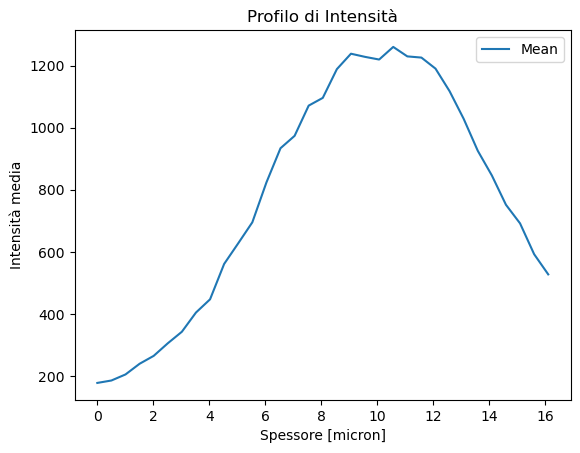

In [2]:
df = pd.read_csv(os.path.join(dir_path, 'data_vera/reni_Z_cervello.csv'))
df.plot(x='[micron]', y='Mean', title='Profilo di Intensità')
plt.xlabel('Spessore [micron]')
plt.ylabel('Intensità media')
plt.show()

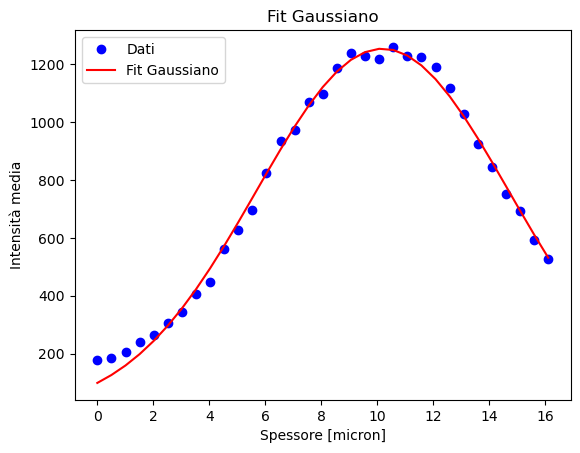

In [3]:
# Fit gaussiano ai dati
x = df['[micron]']
y = df['Mean']

# Funzione gaussiana
def gauss(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

# Stima iniziale dei parametri
A0 = y.max()
mu0 = x[y.idxmax()]
sigma0 = (x.max() - x.min()) / 4

popt, pcov = curve_fit(gauss, x, y, p0=[A0, mu0, sigma0])

# Plot dati e fit
plt.figure()
plt.plot(x, y, 'bo', label='Dati')
plt.plot(x, gauss(x, *popt), 'r-', label='Fit Gaussiano')
plt.xlabel('Spessore [micron]')
plt.ylabel('Intensità media')
plt.title('Fit Gaussiano')
plt.legend()
plt.show()

In [4]:
# Calcolo della FWHM (Full Width at Half Maximum) della gaussiana
A_fit, mu_fit, sigma_fit = popt
fwhm = 2 * np.sqrt(2 * np.log(2)) * sigma_fit
print(f"FWHM della gaussiana: {fwhm:.3f} nm")

fig = go.Figure()

# Dati come scatter (punti limegreen)
fig.add_trace(go.Scatter(
    x=df['[micron]'],
    y=df['Mean'],
    mode='markers',
    name='Dati',
    marker=dict(color='limegreen', size=8)
))

# Fit gaussiano (linea darkgreen)
fig.add_trace(go.Scatter(
    x=x,
    y=gauss(x, *popt),
    mode='lines',
    name='Fit Gaussiano',
    line=dict(color='darkgreen')
))

# Calcola i limiti FWHM
x_fwhm_left = mu_fit - fwhm / 2
x_fwhm_right = mu_fit + fwhm / 2

# Evidenzia la regione FWHM sulla figura Plotly (senza testo nel rettangolo)
fig.add_vrect(
    x0=x_fwhm_left, x1=x_fwhm_right,
    fillcolor="limegreen", opacity=0.2,
    layer="below", line_width=0
)

fig.update_layout(
    title={
        'text': f'FWHM = {fwhm:.2f} micron',
        'x': 0.5,
        'xanchor': 'center',
        'font': dict(color='darkgreen')
    },
    xaxis_title='Spessore [micron]',
    yaxis_title='Grey Value',
    template='plotly_white',
    legend=dict(
        x=0.21, y=0.98,
        xanchor='right', yanchor='top',
        bgcolor='rgba(255,255,255,0.7)',
        bordercolor='black',
        borderwidth=1
    )
)
fig.show()


FWHM della gaussiana: 10.639 nm


# calcolo risoluzione assiale vera

In [5]:
n_olio = 1.518
NA = n_olio * np.sin(np.pi / 6)
l_verde = 500 #  nm

r_assiale = ((l_verde * 1.4 *n_olio) / (NA**2)) * 0.6 / 100
print(f"risoluzione assiale teorica: {r_assiale:.3f} micron")


risoluzione assiale teorica: 11.067 micron


In [6]:
# Test t tra risoluzione assiale empirica (FWHM) e teorica (r_assiale)
# Si assume che la stima empirica abbia incertezza sigma_fit

empirico = fwhm
teorico = r_assiale
sigma = sigma_fit

# Calcolo t-score
t_score = np.abs((empirico - teorico) / sigma)

# Calcolo p-value (test a due code)
p_value = 2 * stats.norm.sf(abs(t_score))

print(f"t = {t_score:.2f}")
print(f"p-value = {p_value:.4f}")

t = 0.09
p-value = 0.9245
